# Training EUR predictive algorithm

This notebook will take a dataframe that holds a training dataset, with additional features (from the completions data) merged, and then build a regression algorithm to predict EUR or EUR per foot (whichever ends up being more accurate).

We'll start with loading the packages and the data:

In [195]:
import numpy as np
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer,accuracy_score, classification_report
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
# load the training dataset
base_merged_train = pd.read_csv('base_train_merged.csv')
base_merged_train['Acid..Gals.'].fillna(0,inplace=True)
# Drop columns that might be correlated / carrying similar information as others
base_merged_train.drop(['Operator','County','Surface.Latitude','Surface.Longitude','Treatment.Records','Completion.Year'],axis=1,inplace=True)

#load the test dataset
base_merged_test = pd.read_csv('base_test_merged.csv')

# Save the id's for predictions
#wellid = base_merged_test.loc['WellID']
#print(wellid)

base_merged_test['Acid..Gals.'].fillna(0,inplace=True)
# Drop columns that might be correlated / carrying similar information as others
base_merged_test.drop(['Operator','County','Surface.Latitude','Surface.Longitude','Treatment.Records','Completion.Year'],axis=1,inplace=True)

#quick check
#base_merged_train.head()
#base_merged_train.head()


Here as we use sklearn, we need to transform categorical values to dummies using one hot encoding. Below we create a function to do that called dummy_val.
LabelEncoder = assigning integer values 0-(k-1), where k is the number of classes
OneHotEncoder = is more suitable for machine learning because the labels are independent to each other. 
- There is probably a better way to do this like selecting df.dtype == 'object' but I had some workable code

In [196]:
def dummy_val(train,test,columns = ['WB.Spacing.Proxy','Deepest_Zone','Subarea','SPBY.Spacing.Proxy','Between_Zone']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

# Setting up the Random Forest Model
## Grid
    - A leaf is a node without any children (external node)
    - min_samples_leaf guarantees a minimum number of samples required to be at each leaf node
    - min_samples_split specifies the minimum number of samples required to split an internal 
    - n_estimators is the number of trees to create before creating predictions
## RF Model
    - Max features set to auto --> will take all features that make sense in every tree (We might want to create restrictions after initial pass)
    - oob_score is a cross validation method
        - tags every observation used in different trees and then finds out a maximum vote score based only on trees that did not use this particular observation to train itself
    - random state makes the process repeatable
## GridSearchCV
    - uses the variables from grid to perform an exhaustive search over specified values
    - make_scorer uses the sklearn.metrics and creates a scoring object
    - GridSearchCV impliments fit method and predict method where the parameters of the classifier used to predict is optimized by cross validation
    - **If I had more time I could create a GridSearchCV to help narrow the parameters for cross validation**
   

In [197]:
# Prep RF and the CV objects:

grid = {      "min_samples_leaf" : [1, 5, 10],
              "min_samples_split" : [2, 4, 10, 12, 16],
              "n_estimators": [50, 150, 300]}
RFmodel = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1)
gs_cv = GridSearchCV(RFmodel,scoring=make_scorer(mean_squared_error),param_grid=grid,n_jobs=-1,cv=3,verbose=1,return_train_score=True)
Xtrain,Xtest = dummy_val(base_merged_train,base_merged_test)


# Crossvalidation techniques

Create instances of both spatial stratified CV and randomly picked CV.
## Stratification by Subarea


## Random folds




In [198]:
Xtrain.dropna(inplace=True)
Xtrain.shape

Xtest.dropna(inplace=True)
#Xtest.shape
x_train = Xtrain.drop(['EUR_o..Mstb.'],axis=1)
y_train = Xtrain['EUR_o..Mstb.']


In [199]:
gs_cv.fit(Xtrain.drop(['EUR_o..Mstb.'],axis=1),Xtrain['EUR_o..Mstb.'])

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 4, 10, 12, 16], 'n_estimators': [50, 150, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error), verbose=1)

In [200]:
# Given more time it would be better to plot these fits
results = gs_cv.cv_results_
gs_cv.cv_results_

{'mean_fit_time': array([1.39284976, 4.16490364, 8.32862465, 1.22421837, 3.69015018,
        7.34349887, 1.05714409, 3.2119743 , 6.38035011, 1.03276976,
        3.14883089, 6.29641271, 0.96688493, 2.95964495, 5.88600628,
        0.84548227, 2.58464575, 5.1696705 , 0.84054017, 2.58374715,
        5.10218143, 0.85151982, 2.55333575, 5.09184782, 0.83956742,
        2.53204576, 5.0197134 , 0.79617182, 2.4542826 , 4.89984902,
        0.68702785, 2.08675377, 4.18807316, 0.6941638 , 2.07701969,
        4.19943412, 0.72802862, 2.06653635, 4.18159175, 0.70584059,
        2.06292367, 4.2055645 , 0.71302358, 2.06576864, 3.65336108]),
 'std_fit_time': array([0.11020415, 0.35141285, 0.63568152, 0.10768931, 0.32577972,
        0.62571805, 0.10426236, 0.29328601, 0.57590892, 0.10596239,
        0.32655871, 0.51758197, 0.09018182, 0.28482869, 0.60537865,
        0.05763782, 0.16554778, 0.34940619, 0.05439   , 0.15611767,
        0.33629319, 0.05136808, 0.17244937, 0.33417559, 0.05331252,
        0.132

In [201]:
#importance = list(RFmodel.feature_importances_)
best_grid = gs_cv.best_params_
print(gs_cv.best_params_)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [202]:
best_RFmodel = gs_cv.best_estimator_
print(gs_cv.best_estimator_)
#grid_accuracy = evaluate(best_grid, test_features, test_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)


In [203]:
x_test = Xtest
y_pred = best_RFmodel.predict(x_train)

In [204]:
# Check the RMSE
np.sqrt(np.mean((y_pred - y_train)**2)*(1/len(y_pred)))

0.2606358953916488

In [205]:
# Estimate performance on unseen data
np.sqrt(np.mean((best_RFmodel.oob_prediction_ - y_train)**2)*(1/len(y_pred)))

0.702045314664236

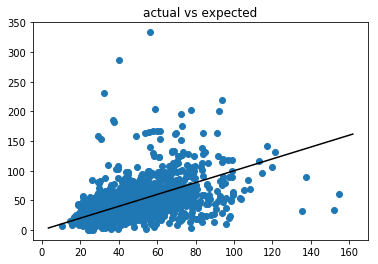

In [206]:
# Actual vs expected
fig, ax = plt.subplots()
plt.scatter(best_RFmodel.oob_prediction_, y_train)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color = 'black')
plt.title('actual vs expected')
plt.show()

In [207]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
lreg.fit(x_train,y_train)
lpred = lreg.predict(x_train)
np.sqrt(np.mean((lpred - y_train)**2)*(1/len(y_pred)))

0.637523649012948

# Finally create the predictions

In [208]:
y_sub = best_RFmodel.predict(x_test)

In [225]:
print(y_sub)

[42.32693395 37.27769814 39.10633556 ... 78.51163754 77.71627193
 83.73027121]


In [222]:
wid = Xtest.WellID

In [228]:
output = pd.DataFrame({'WellID' : wid, 'EUR_o..Mstb' : y_sub})
output.to_csv('RandomForest_benchmarkLM.csv', index=False)

# Overview and Recommendations 

## Overview

### EDA
- Initial recon of the data
- Create plots to gain a better understanding
- Generate an overview of statistics 
- Figure out how to normalize and calibrate the data

### Modeling
- More data prep like encoding categorical variables, removing NaN, dropping useless vars
- Create some general models to obtain a benchmark
- Once you have say linear regression working you could use regularized regression (Ridge/Lasso) to obtain a more general model
- See if you need to attempt a more complex model like SVM, kNN, RF, etc. 
- Model selection with GridSearchCV and create plots of model stats (classification report)
- Test model against benchmark

## Recommendations
- Quantile regression forests .. this is useful when there are a number of outliers which can influence the conditional mean. (See skgarden)
- Keras is a deel learning framework that has an API designed for humans. Easy to learn and easy to use. Easy implimentation and GPU/distributed training support
- Use MVA to relate well performance to a seismic inversion based on petrophysical relationships that can be calibrated with core data. 
- Azimuthal data?

